In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

In [8]:
curr_dir = os.getcwd()
curr_dir

'C:\\weather\\uv'

In [9]:
forders_tr = os.listdir(curr_dir+"\\data\\"+"\\train_val")
forders_tr

['202001_uv.csv',
 '202002_uv.csv',
 '202003_uv.csv',
 '202004_uv.csv',
 '202005_uv.csv',
 '202006_uv.csv',
 '202007_uv.csv',
 '202008_uv.csv',
 '202009_uv.csv',
 '202010_uv.csv',
 '202011_uv.csv',
 '202012_uv.csv',
 '202101_uv.csv',
 '202102_uv.csv',
 '202103_uv.csv',
 '202104_uv.csv',
 '202105_uv.csv',
 '202106_uv.csv',
 '202107_uv.csv',
 '202108_uv.csv',
 '202109_uv.csv',
 '202110_uv.csv',
 '202111_uv.csv',
 '202112_uv.csv']

In [10]:
forders_tr1 = []
for i in range(0,9):
    df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\train_val\\")+forders_tr[i])
    d = list(df.columns)
    for j in range(1,len(d)):
        d[j] = d[j].replace("20200"+str(i+1)+"_uv.", "")
    df.columns = d
    df.drop('Unnamed: 0', axis=1, inplace=True)
    forders_tr1.append(df)

for i in range(9,12):
    df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\train_val\\")+forders_tr[i])
    d = list(df.columns)
    for j in range(1,len(d)):
        d[j] = d[j].replace("2020"+str(i+1)+"_uv.", "")
    df.columns = d
    df.drop('Unnamed: 0', axis=1, inplace=True)
    forders_tr1.append(df)

    
for i in range(12,21):
    df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\train_val\\")+forders_tr[i])
    d = list(df.columns)
    for j in range(1,len(d)):
        d[j] = d[j].replace("20210"+str(i+1-12)+"_uv.", "")
    df.columns = d
    df.drop('Unnamed: 0', axis=1, inplace=True)
    forders_tr1.append(df)

for i in range(21,24):
    df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\train_val\\")+forders_tr[i])
    d = list(df.columns)
    for j in range(1,len(d)):
        d[j] = d[j].replace("2021"+str(i+1-12)+"_uv.", "")
    df.columns = d
    df.drop('Unnamed: 0', axis=1, inplace=True)
    forders_tr1.append(df)

In [11]:
# 새로운 데이터 프레임 생성
train = pd.DataFrame()

for files in forders_tr1[:-5]:
    train = pd.concat([train, files])
train

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20200101,0,13,126.16000,33.30000,0.0,0.00000,0.00000,0.00000,-0.00075,...,250.75924,269.97608,269.70811,268.61702,259.10334,165.17963,38.96359,-9.50910,71.00,0
1,20200101,0,105,128.89098,37.75147,0.0,-0.00057,0.00057,0.00030,-0.00030,...,246.67115,268.22810,268.41686,268.01723,256.99670,163.20549,43.95463,-9.40930,26.04,3
2,20200101,0,108,126.96500,37.57100,-999.0,0.00000,0.00000,-0.00089,-0.00075,...,241.24994,258.33982,258.18692,257.58363,250.50021,162.48279,43.77999,-9.37761,85.50,3
3,20200101,0,112,126.62490,37.47772,0.0,-0.00057,-0.00057,-0.00060,0.00015,...,241.55488,258.54927,258.64012,258.03883,251.00820,162.39995,43.67046,-9.37422,68.99,3
4,20200101,0,115,130.89864,37.48129,0.0,0.00000,-0.00057,-0.00030,0.00075,...,244.56708,264.88004,263.95472,262.33534,253.25397,164.19725,43.74521,-9.45200,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66955,20210731,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00060,...,264.53165,291.90287,290.09587,285.48855,270.82702,124.36364,41.81018,-4.72602,62.90,3
66956,20210731,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,0.00000,-0.00030,...,262.88449,288.27382,286.67481,282.45891,269.23268,125.09137,41.52495,-4.87156,82.00,2
66957,20210731,2350,156,126.89158,35.17294,0.0,-0.00057,0.00000,0.00000,0.00015,...,262.57588,287.50208,284.96722,280.05240,267.56515,124.95628,41.04849,-4.79509,72.38,3
66958,20210731,2350,159,129.03203,35.10468,0.0,0.00000,0.00000,-0.00119,0.00000,...,262.22936,287.43410,286.66069,283.63739,270.60537,125.49764,40.96396,-4.91507,69.56,3


In [29]:
train['uv'].value_counts()             # -999많음.

 0.0      623140
 0.1       54484
-999.0     49316
 0.2       32427
 0.3       25304
           ...  
 12.5          3
 13.3          1
 13.7          1
 14.4          1
 18.9          1
Name: uv, Length: 138, dtype: int64

In [6]:
train.describe()

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
count,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,...,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06,1.248480e+06
mean,2.020424e+07,1.175000e+03,1.272000e+02,1.278316e+02,3.610407e+01,-3.835470e+01,-1.053349e+01,-1.053726e+01,-1.054433e+01,-1.052727e+01,...,2.363966e+02,2.578804e+02,2.573527e+02,2.555400e+02,2.443359e+02,8.757669e+01,4.211422e+01,1.419884e-01,6.863933e+01,2.400000e+00
std,4.708585e+03,6.924296e+02,3.555129e+01,1.376363e+00,1.182672e+00,1.948232e+02,1.025317e+02,1.025313e+02,1.025306e+02,1.025324e+02,...,1.285245e+02,1.315599e+02,1.315511e+02,1.312832e+02,1.295936e+02,3.809067e+01,1.339209e+00,5.428745e+00,4.635743e+01,1.254326e+00
min,2.020010e+07,0.000000e+00,1.300000e+01,1.261600e+02,3.330000e+01,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,...,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,9.868750e+00,3.896359e+01,-9.630860e+00,2.280000e+00,0.000000e+00
25%,2.020052e+07,5.875000e+02,1.120000e+02,1.266249e+02,3.517294e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.430064e+02,2.604644e+02,2.595766e+02,2.581334e+02,2.504595e+02,5.734223e+01,4.104849e+01,-4.624192e+00,4.700000e+01,2.000000e+00
50%,2.020102e+07,1.175000e+03,1.330000e+02,1.273721e+02,3.603259e+01,0.000000e+00,1.190000e-02,1.026000e-02,6.560000e-03,7.330000e-03,...,2.499938e+02,2.743748e+02,2.741352e+02,2.726281e+02,2.604117e+02,8.770950e+01,4.202608e+01,2.500250e-01,6.894000e+01,3.000000e+00
75%,2.021031e+07,1.762500e+03,1.520000e+02,1.290320e+02,3.747772e+01,1.300000e+00,1.461600e-01,1.345800e-01,1.135500e-01,1.574100e-01,...,2.570283e+02,2.845072e+02,2.844209e+02,2.823070e+02,2.673201e+02,1.186834e+02,4.367046e+01,4.986640e+00,7.238000e+01,3.000000e+00
max,2.021073e+07,2.350000e+03,1.650000e+02,1.308986e+02,3.775147e+01,1.890000e+01,1.148280e+00,1.155940e+00,1.122040e+00,1.133730e+00,...,3.072160e+02,3.112966e+02,3.102730e+02,3.051737e+02,2.815333e+02,1.700420e+02,4.395463e+01,9.025490e+00,2.228000e+02,4.000000e+00


In [12]:
train1 = train[train['uv'] != -999.0]
train1

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20200101,0,13,126.16000,33.30000,0.0,0.00000,0.00000,0.00000,-0.00075,...,250.75924,269.97608,269.70811,268.61702,259.10334,165.17963,38.96359,-9.50910,71.00,0
1,20200101,0,105,128.89098,37.75147,0.0,-0.00057,0.00057,0.00030,-0.00030,...,246.67115,268.22810,268.41686,268.01723,256.99670,163.20549,43.95463,-9.40930,26.04,3
3,20200101,0,112,126.62490,37.47772,0.0,-0.00057,-0.00057,-0.00060,0.00015,...,241.55488,258.54927,258.64012,258.03883,251.00820,162.39995,43.67046,-9.37422,68.99,3
4,20200101,0,115,130.89864,37.48129,0.0,0.00000,-0.00057,-0.00030,0.00075,...,244.56708,264.88004,263.95472,262.33534,253.25397,164.19725,43.74521,-9.45200,222.80,4
5,20200101,0,131,127.44066,36.63924,0.0,0.00000,0.00000,0.00000,-0.00015,...,245.02255,263.96330,264.23788,263.88311,254.98555,163.46199,42.69599,-9.42573,58.70,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66955,20210731,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00060,...,264.53165,291.90287,290.09587,285.48855,270.82702,124.36364,41.81018,-4.72602,62.90,3
66956,20210731,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,0.00000,-0.00030,...,262.88449,288.27382,286.67481,282.45891,269.23268,125.09137,41.52495,-4.87156,82.00,2
66957,20210731,2350,156,126.89158,35.17294,0.0,-0.00057,0.00000,0.00000,0.00015,...,262.57588,287.50208,284.96722,280.05240,267.56515,124.95628,41.04849,-4.79509,72.38,3
66958,20210731,2350,159,129.03203,35.10468,0.0,0.00000,0.00000,-0.00119,0.00000,...,262.22936,287.43410,286.66069,283.63739,270.60537,125.49764,40.96396,-4.91507,69.56,3


In [13]:
val = pd.DataFrame()

for files in forders_tr1[-5:]:
    val = pd.concat([val, files])
val

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20210801,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,0.00089,-0.00015,...,264.44311,290.55389,288.92546,284.67080,270.70772,127.16116,38.96359,-5.60122,71.00,0
1,20210801,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,0.00000,-0.00015,...,259.14507,283.10942,282.76528,280.43877,268.61000,123.36327,43.95463,-5.09260,26.04,3
2,20210801,0,108,126.96500,37.57100,0.0,0.00000,0.00057,-0.00119,0.00120,...,252.93837,273.65182,270.18990,267.15459,258.99048,123.18739,43.77999,-5.07447,85.50,3
3,20210801,0,112,126.62490,37.47772,0.0,0.00000,0.00000,-0.00030,-0.00060,...,250.27920,268.14394,268.04466,266.56403,259.34748,123.22507,43.67046,-5.08058,68.99,3
4,20210801,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00000,-0.00015,...,263.38986,289.67998,288.05013,284.04277,269.26719,123.91259,43.74521,-5.16058,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66955,20211231,2350,146,127.11900,35.84080,0.1,-0.00057,0.00000,-0.00060,0.00000,...,244.71129,264.82744,264.95943,264.36433,254.82929,162.52921,41.81018,-8.87355,62.90,3
66956,20211231,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,-0.00179,-0.00015,...,241.75728,259.19303,257.86443,257.39333,249.08495,163.96606,41.52495,-8.99640,82.00,2
66957,20211231,2350,156,126.89158,35.17294,0.0,0.00000,0.00000,0.00000,0.00105,...,242.90744,260.33453,260.00405,259.18646,250.92709,162.84572,41.04849,-8.87987,72.38,3
66958,20211231,2350,159,129.03203,35.10468,0.0,-0.00057,-0.00057,0.00089,-0.00015,...,242.68420,259.36253,258.24370,256.93511,247.71243,164.15158,40.96396,-8.99480,69.56,3


In [14]:
val['uv'].value_counts()             # -999많음.

0.0     171262
0.1      25675
0.2       8945
0.3       6935
0.4       6667
         ...  
18.5         1
11.8         1
23.6         1
13.3         1
12.4         1
Name: uv, Length: 131, dtype: int64

In [15]:
val1 = val[val['uv'] != -999.0]
val1

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20210801,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,0.00089,-0.00015,...,264.44311,290.55389,288.92546,284.67080,270.70772,127.16116,38.96359,-5.60122,71.00,0
1,20210801,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,0.00000,-0.00015,...,259.14507,283.10942,282.76528,280.43877,268.61000,123.36327,43.95463,-5.09260,26.04,3
2,20210801,0,108,126.96500,37.57100,0.0,0.00000,0.00057,-0.00119,0.00120,...,252.93837,273.65182,270.18990,267.15459,258.99048,123.18739,43.77999,-5.07447,85.50,3
3,20210801,0,112,126.62490,37.47772,0.0,0.00000,0.00000,-0.00030,-0.00060,...,250.27920,268.14394,268.04466,266.56403,259.34748,123.22507,43.67046,-5.08058,68.99,3
4,20210801,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00000,-0.00015,...,263.38986,289.67998,288.05013,284.04277,269.26719,123.91259,43.74521,-5.16058,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66955,20211231,2350,146,127.11900,35.84080,0.1,-0.00057,0.00000,-0.00060,0.00000,...,244.71129,264.82744,264.95943,264.36433,254.82929,162.52921,41.81018,-8.87355,62.90,3
66956,20211231,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,-0.00179,-0.00015,...,241.75728,259.19303,257.86443,257.39333,249.08495,163.96606,41.52495,-8.99640,82.00,2
66957,20211231,2350,156,126.89158,35.17294,0.0,0.00000,0.00000,0.00000,0.00105,...,242.90744,260.33453,260.00405,259.18646,250.92709,162.84572,41.04849,-8.87987,72.38,3
66958,20211231,2350,159,129.03203,35.10468,0.0,-0.00057,-0.00057,0.00089,-0.00015,...,242.68420,259.36253,258.24370,256.93511,247.71243,164.15158,40.96396,-8.99480,69.56,3


In [16]:
forders_te = os.listdir(curr_dir+"\\data\\"+"\\test")
forders_te

df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\test\\")+forders_te[0])
d = list(df.columns)
for j in range(1,len(d)):
    d[j] = d[j].replace("202206_uv.", "")
df.columns = d
df.drop('Unnamed: 0', axis=1, inplace=True)
test = df
test

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20220601,0,13,126.16000,33.30000,NaN,0.00000,0.00000,-0.00060,0.00060,...,241.07130,251.49092,250.11913,248.78686,243.12601,-999,38.96359,-999,71.00,0
1,20220601,0,105,128.89098,37.75147,NaN,-0.00057,-0.00057,0.00000,-0.00030,...,244.35010,262.71227,261.14580,257.52658,246.95577,-999,43.95463,-999,26.04,3
2,20220601,0,108,126.96500,37.57100,NaN,0.00000,-0.00057,-0.00030,0.00045,...,249.24111,271.81756,270.25616,266.99858,254.94651,-999,43.77999,-999,85.50,3
3,20220601,0,112,126.62490,37.47772,NaN,0.00000,0.00000,0.00060,0.00045,...,249.94977,273.52547,272.33661,269.12853,256.15036,-999,43.67046,-999,68.99,3
4,20220601,0,115,130.89864,37.48129,NaN,0.00000,0.00000,0.00089,-0.00030,...,239.88321,253.29031,251.46606,249.01625,240.92761,-999,43.74521,-999,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,NaN,0.00000,-0.00057,-0.00089,0.00015,...,258.49191,286.87485,287.19605,285.48855,271.35400,-999,41.81018,-999,62.90,3
51851,20220625,0,152,129.33472,35.58250,NaN,-0.00057,0.00000,-0.00030,-0.00030,...,263.99872,293.32422,293.51096,291.15861,274.60342,-999,41.52495,-999,82.00,2
51852,20220625,0,156,126.89158,35.17294,NaN,0.00000,0.00000,0.00089,-0.00030,...,261.53112,290.14436,290.23278,288.05655,273.15633,-999,41.04849,-999,72.38,3
51853,20220625,0,159,129.03203,35.10468,NaN,0.00000,0.00057,0.00030,-0.00075,...,260.95627,287.80066,287.63090,285.01340,270.36623,-999,40.96396,-999,69.56,3


# corr

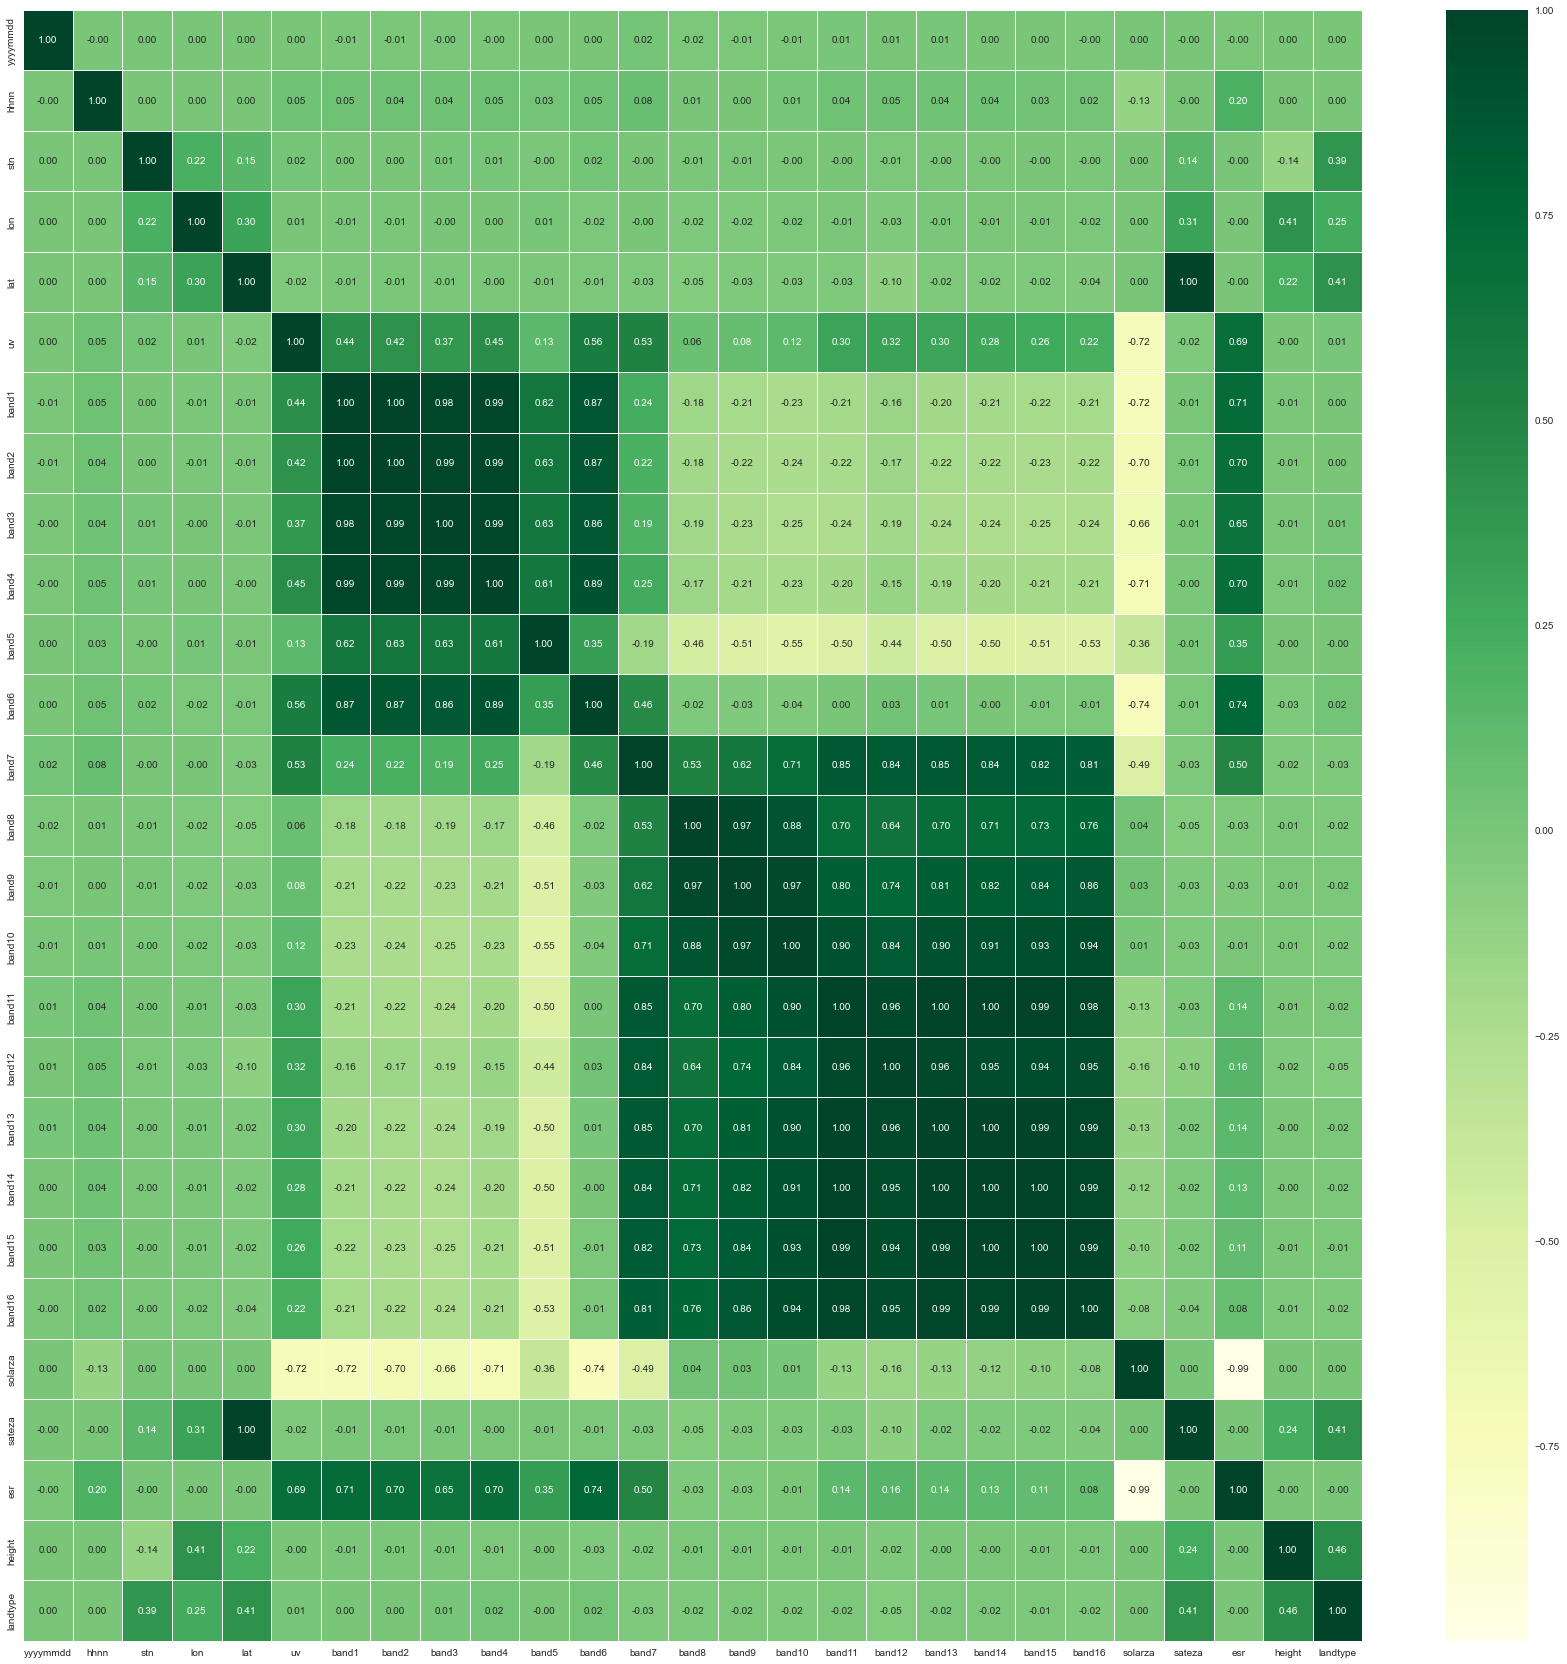

In [120]:
# outlier 제거
mask = train.isin([-999.0])
train1 = train[~mask]
# df2 = df1.drop([])
# train1.describe()

plt.figure(figsize=(30,30))
plt.style.use('seaborn')
sns.heatmap(data = train1.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='YlGn')
plt.savefig('corr_uv.png')

In [111]:
train.columns

Index(['Unnamed: 0', 'yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'band1',
       'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9',
       'band10', 'band11', 'band12', 'band13', 'band14', 'band15', 'band16',
       'solarza', 'sateza', 'esr', 'height', 'landtype'],
      dtype='object')

In [18]:
max_depth = 5
n_estimators = 5000             # 400  #1000
lr = 0.01                     # 0.017
num_leaves = 31
early_stopping_rounds = 300      # 100
verbose = True                  # True

In [19]:
# def model_train(curr_dir):
 
#     path_train = os.path.join(curr_dir+"\\data_rota\\"+"\\train")
#     path_test = os.path.join(curr_dir+"\\data_rota\\"+"\\test")
    
#     folders_tr = os.listdir(path_train)
#     folders_test = os.listdir(path_test)
    
#     train = pd.DataFrame()
#     for files in folders_tr:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\train\\")+files)
#         train = pd.concat([train, df])            
              
    
#     test = pd.DataFrame()
#     for files in folders_test:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\test\\")+files)
#         test = pd.concat([test, df])   


#     X_train = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     X_val = val[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]    
#     X_test = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
 
X_train = train1.drop('uv',axis=1)
X_val = val1.drop('uv',axis=1)
X_test = test.drop('uv',axis=1)
    
y_train = train1[['uv']].values
y_val = val1[['uv']].values



#     trainx = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     test1 = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
    
#     trainy = train[['uv']].values

#     X_train, X_val, y_train, y_val = train_test_split(trainx, trainy, test_size=0.3, shuffle=False)
    
#     param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [None, 6, 9, 12],
#     'min_samples_split': [0.01, 0.05, 0.1],
#     'max_features': ['auto', 'sqrt']}
    
    
#     kf = KFold(random_state=30,
#            n_splits=3,
#            shuffle=True,
#           )
    
#     model_name = '\\save\\'+'best_model_v1.h5' 

#     filepath = os.path.join(os.getcwd()+ model_name)

#     es = EarlyStopping(monitor='val_mse', verbose=1, patience=20)

#     checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_mse',
#                              verbose=1,
#                              save_best_only=True)

#     callbacks = [checkpoint, es]



# xgb_model = xgb.XGBRegressor(n_estimators = 25000, learning_rate = 0.01, \
#                               max_depth=5, subsample=0.5,colsample_bytree=0.7,  \
#                     random_state = 2000)

# xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)



lgbm_reg = LGBMRegressor(objective= "regression",
                     max_depth= max_depth,
                     n_estimators= n_estimators,
                     learning_rate= lr,
                     num_leaves = num_leaves)
    
lgbm_reg.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric=["mse"],
          early_stopping_rounds=early_stopping_rounds,
          verbose=verbose) 



#     estimator = xgb.XGBRegressor()
    # define grid_search
#     grid_search = GridSearchCV(estimator=estimator, 
#                                param_grid=param_grid, 
#                                cv=kf, 
#                                n_jobs=-1, 
#                                verbose=2
#                               )

    # fit with (x_train, y_train)
#     grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=1)
    
#     feature_importance = xgb_model.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     fig = plt.figure(figsize=(12, 6))
#     plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
#     plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
#     plt.title('Feature Importance')
    
#     pred = xgb_model.predict(test1)
#     submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
#     submission1=submission.copy()
#     submission1['UV'] = pred
    
#     submission1.to_csv("220224_xgb_uv.csv", index = False)

C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[1]	valid_0's l2: 2.90233
[2]	valid_0's l2: 2.85355
[3]	valid_0's l2: 2.80572
[4]	valid_0's l2: 2.75877
[5]	valid_0's l2: 2.71241
[6]	valid_0's l2: 2.66682
[7]	valid_0's l2: 2.62219
[8]	valid_0's l2: 2.57869
[9]	valid_0's l2: 2.53578
[10]	valid_0's l2: 2.49396
[11]	valid_0's l2: 2.45263
[12]	valid_0's l2: 2.41221
[13]	valid_0's l2: 2.37218
[14]	valid_0's l2: 2.33342
[15]	valid_0's l2: 2.29599
[16]	valid_0's l2: 2.25823
[17]	valid_0's l2: 2.22226
[18]	valid_0's l2: 2.18634
[19]	valid_0's l2: 2.15056
[20]	valid_0's l2: 2.11606
[21]	valid_0's l2: 2.08172
[22]	valid_0's l2: 2.04777
[23]	valid_0's l2: 2.01563
[24]	valid_0's l2: 1.98338
[25]	valid_0's l2: 1.95143
[26]	valid_0's l2: 1.92104
[27]	valid_0's l2: 1.89098
[28]	valid_0's l2: 1.86119
[29]	valid_0's l2: 1.83175
[30]	valid_0's l2: 1.80264
[31]	valid_0's l2: 1.77529
[32]	valid_0's l2: 1.74726
[33]	valid_0's l2: 1.72011
[34]	valid_0's l2: 1.69429
[35]	valid_0's l2: 1.66773
[36]	valid_0's l2: 1.64287
[37]	valid_0's l2: 1.61734
[38]	valid

[291]	valid_0's l2: 0.218684
[292]	valid_0's l2: 0.218143
[293]	valid_0's l2: 0.217699
[294]	valid_0's l2: 0.217167
[295]	valid_0's l2: 0.216675
[296]	valid_0's l2: 0.216017
[297]	valid_0's l2: 0.215523
[298]	valid_0's l2: 0.215097
[299]	valid_0's l2: 0.214666
[300]	valid_0's l2: 0.214254
[301]	valid_0's l2: 0.213717
[302]	valid_0's l2: 0.213245
[303]	valid_0's l2: 0.212878
[304]	valid_0's l2: 0.212341
[305]	valid_0's l2: 0.211885
[306]	valid_0's l2: 0.211331
[307]	valid_0's l2: 0.21092
[308]	valid_0's l2: 0.210505
[309]	valid_0's l2: 0.209958
[310]	valid_0's l2: 0.209663
[311]	valid_0's l2: 0.209197
[312]	valid_0's l2: 0.208514
[313]	valid_0's l2: 0.208038
[314]	valid_0's l2: 0.207882
[315]	valid_0's l2: 0.207449
[316]	valid_0's l2: 0.207243
[317]	valid_0's l2: 0.206854
[318]	valid_0's l2: 0.206208
[319]	valid_0's l2: 0.205877
[320]	valid_0's l2: 0.205505
[321]	valid_0's l2: 0.205185
[322]	valid_0's l2: 0.20484
[323]	valid_0's l2: 0.204501
[324]	valid_0's l2: 0.204158
[325]	valid_0's 

[577]	valid_0's l2: 0.171554
[578]	valid_0's l2: 0.171533
[579]	valid_0's l2: 0.171492
[580]	valid_0's l2: 0.171494
[581]	valid_0's l2: 0.171463
[582]	valid_0's l2: 0.171439
[583]	valid_0's l2: 0.171374
[584]	valid_0's l2: 0.17138
[585]	valid_0's l2: 0.171347
[586]	valid_0's l2: 0.171363
[587]	valid_0's l2: 0.171323
[588]	valid_0's l2: 0.171287
[589]	valid_0's l2: 0.171242
[590]	valid_0's l2: 0.171152
[591]	valid_0's l2: 0.171114
[592]	valid_0's l2: 0.171111
[593]	valid_0's l2: 0.171045
[594]	valid_0's l2: 0.171023
[595]	valid_0's l2: 0.171051
[596]	valid_0's l2: 0.171079
[597]	valid_0's l2: 0.171054
[598]	valid_0's l2: 0.171035
[599]	valid_0's l2: 0.17101
[600]	valid_0's l2: 0.170869
[601]	valid_0's l2: 0.17083
[602]	valid_0's l2: 0.170847
[603]	valid_0's l2: 0.170807
[604]	valid_0's l2: 0.170835
[605]	valid_0's l2: 0.170758
[606]	valid_0's l2: 0.170725
[607]	valid_0's l2: 0.170707
[608]	valid_0's l2: 0.170568
[609]	valid_0's l2: 0.170506
[610]	valid_0's l2: 0.170493
[611]	valid_0's l

[864]	valid_0's l2: 0.168842
[865]	valid_0's l2: 0.168819
[866]	valid_0's l2: 0.168802
[867]	valid_0's l2: 0.168789
[868]	valid_0's l2: 0.168803
[869]	valid_0's l2: 0.168807
[870]	valid_0's l2: 0.168813
[871]	valid_0's l2: 0.168844
[872]	valid_0's l2: 0.168817
[873]	valid_0's l2: 0.168789
[874]	valid_0's l2: 0.16877
[875]	valid_0's l2: 0.168749
[876]	valid_0's l2: 0.168773
[877]	valid_0's l2: 0.168796
[878]	valid_0's l2: 0.168779
[879]	valid_0's l2: 0.168759
[880]	valid_0's l2: 0.168738
[881]	valid_0's l2: 0.168735
[882]	valid_0's l2: 0.168736
[883]	valid_0's l2: 0.168746
[884]	valid_0's l2: 0.168758
[885]	valid_0's l2: 0.168734
[886]	valid_0's l2: 0.168762
[887]	valid_0's l2: 0.168763
[888]	valid_0's l2: 0.168747
[889]	valid_0's l2: 0.168751
[890]	valid_0's l2: 0.168732
[891]	valid_0's l2: 0.168758
[892]	valid_0's l2: 0.168769
[893]	valid_0's l2: 0.168769
[894]	valid_0's l2: 0.168747
[895]	valid_0's l2: 0.168724
[896]	valid_0's l2: 0.168701
[897]	valid_0's l2: 0.168728
[898]	valid_0's

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=5000,
              objective='regression')

In [14]:
# pred_te = lgbm_reg.predict(X_val)
# pred_te

array([9.19385712e-07, 2.57823475e-07, 2.57823475e-07, ...,
       2.57823475e-07, 1.41195293e-06, 1.41195293e-06])

In [35]:
# df = pd.DataFrame(pred_te)
# df[0].value_counts()

 2.578235e-07    130735
 1.411953e-06     20470
 9.999966e-02     13571
 9.193857e-07      6506
-9.990000e+02      2090
                  ...  
 2.300005e+00         1
 1.700031e+00         1
 2.299988e+00         1
 1.800014e+00         1
 6.000000e-01         1
Name: 0, Length: 59292, dtype: int64

In [20]:
# re = y_val.flatten()
# re

array([0., 0., 0., ..., 0., 0., 0.])

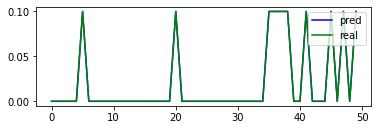

In [24]:
# plt.subplot(211)
# plt.plot(pred_te[500:550], color = 'b', label = 'pred')
# plt.plot(re[500:550], color = 'g', label = 'real')
# # plt.ylabel('LST')
# plt.legend()
# plt.show()  

In [22]:
pred = lgbm_reg.predict(X_test)
submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
submission1=submission.copy()
submission1['UV'] = pred
submission1
submission1.to_csv("220224_lgbm_uv.csv", index = False)

In [23]:
submission1

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,7.629831
1,202206010000,105,8.070375
2,202206010000,108,6.982485
3,202206010000,112,8.111956
4,202206010000,115,8.105170
...,...,...,...
51850,202206250000,146,6.674783
51851,202206250000,152,8.714616
51852,202206250000,156,8.065850
51853,202206250000,159,9.611854


In [21]:
submission1['UV'].value_counts()     # 정렬해서 보기

8.390056    55
8.185661    50
7.934211    40
7.836354    38
9.083756    37
            ..
7.779831     1
8.879754     1
7.992504     1
8.060087     1
7.392131     1
Name: UV, Length: 40321, dtype: int64

In [ ]:
# corr에만 의존(이건 회귀분석에서!딥러닝은 안그렇다)이 아니라, 모든 피쳐넣어도 잘될 떄 있다!! => 실제로도 수렴 잘 됨
# 그리고 결측치 행제거해서도 해볼것!!!!!

In [ ]:
# grid_search.best_params_

In [ ]:
# radom으로 안 나누고 임의로 train,val 분할해주니 그래도 더 나은듯함.